In [153]:
import pandas as pd
import numpy as np

In [154]:
data = pd.read_csv("data/test.csv")
data.head()

,pid,seq,act,start,end,duration
0,0,1,home,0,9,9
1,0,2,work,9,16,7
2,0,3,home,16,21,5
3,0,4,work,21,22,1
4,0,5,home,22,24,2


In [156]:
set(data.act)

{'education', 'home', 'shop', 'work'}

In [157]:
len(set(data.pid))

10000

In [158]:
input_dim = (24, 4, 1)  # hours, acts
mapping = {
    "home": 0,
    "work": 1,
    "shop": 2,
    "education": 3
}

In [159]:
encoded = np.zeros((10000,24,4,1))

for pid, day in data.groupby("pid"):
    for act, start, end in zip(day.act, day.start, day.end):
        index = mapping[act]
        for hour in range(start, end):
            encoded[pid, hour, index, 0] = 1
            
encoded.shape 

(10000, 24, 4, 1)

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from scipy.stats import norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from models.VAE import VAE
from utils.loaders import load_mnist, load_model

In [161]:
# run params
SECTION = 'caveat'
RUN_ID = '0001'
DATA_NAME = 'acts'
RUN_FOLDER = Path(f'run/{SECTION}')
RUN_FOLDER = RUN_FOLDER / Path('_'.join([RUN_ID, DATA_NAME]))
MODE =  'build' #'load' #

if not RUN_FOLDER.exists():
    RUN_FOLDER.mkdir(parents=True, exist_ok=True)
    for ext in [Path('viz'), Path('images'), Path('weights')]:
        (RUN_FOLDER / ext).mkdir(parents=True, exist_ok=False)

In [192]:
vae = VAE(
    input_dim = (24,4,1),
    encoder_conv_filters = [16,8,8,4],
    encoder_conv_kernel_size = [2,2,2,2],
    encoder_conv_strides = [1,1,1,1],
    decoder_conv_t_filters = [16,8,8,1],
    decoder_conv_t_kernel_size = [2,2,2,2],
    decoder_conv_t_strides = [1,1,1,1],
    z_dim = 2,
)

if MODE == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [193]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
BATCH_SIZE = 100
EPOCHS = 20
PRINT_EVERY_N_BATCHES = 1000
INITIAL_EPOCH = 0.0005

In [194]:
optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(
    optimizer=optimizer,
    reconstruction_weight=R_LOSS_FACTOR,
    learning_rate=LEARNING_RATE
)

vae.fit(
    encoded,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = 0,
    lr_decay = 1,
)

Epoch 1/20
100/100 [==============================] - 3s 26ms/step - loss: 228.8843 - reconstruction_loss: 197.3980 - kl_loss: 1.2967

Epoch 00001: saving model to run/caveat/0001_acts/weights/weights-001-198.69.h5

Epoch 00001: saving model to run/caveat/0001_acts/weights/weights.h5
Epoch 2/20
100/100 [==============================] - 2s 25ms/step - loss: 132.2315 - reconstruction_loss: 120.4758 - kl_loss: 3.4468

Epoch 00002: saving model to run/caveat/0001_acts/weights/weights-002-123.92.h5

Epoch 00002: saving model to run/caveat/0001_acts/weights/weights.h5
Epoch 3/20
100/100 [==============================] - 3s 25ms/step - loss: 96.2167 - reconstruction_loss: 84.0163 - kl_loss: 4.5286

Epoch 00003: saving model to run/caveat/0001_acts/weights/weights-003-88.54.h5

Epoch 00003: saving model to run/caveat/0001_acts/weights/weights.h5
Epoch 4/20
100/100 [==============================] - 2s 24ms/step - loss: 72.1563 - reconstruction_loss: 65.8304 - kl_loss: 3.8874

Epoch 00004: sa

In [195]:
vae = load_model(VAE, RUN_FOLDER)

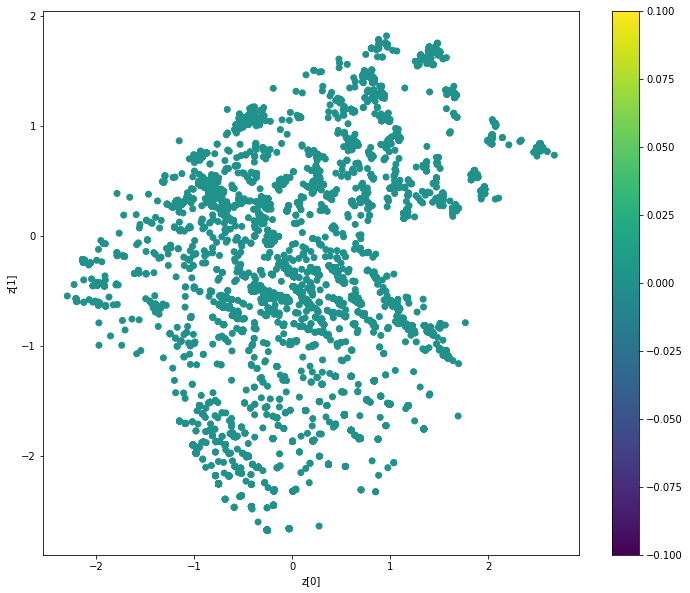

In [196]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, encoded, np.zeros((10000)))

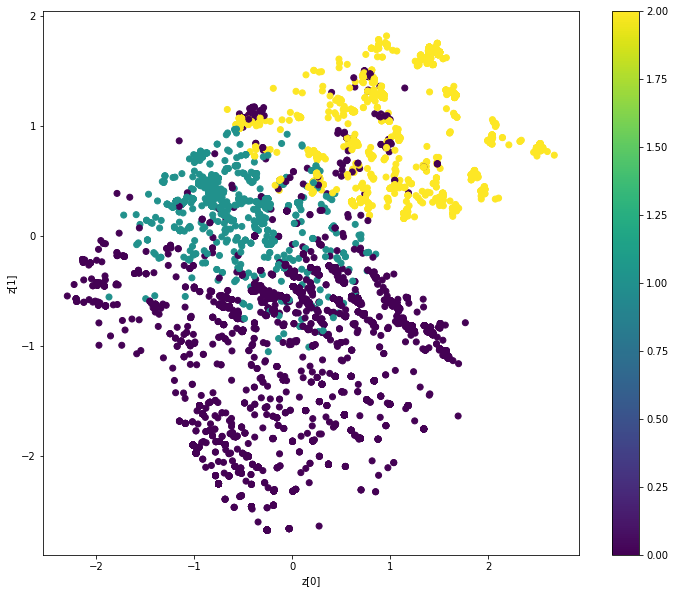

In [197]:
labels = pd.read_csv("data/test_labels.csv")
plot_label_clusters(vae, encoded, labels.label.array)

In [198]:
def decode(array):
    mapping = {
        0: "home",
        1: "work",
        2: "shop",
        3: "education"
    }
    return [mapping[hour.argmax()] for hour in array[0,:]]

In [199]:
z_sample = np.array([[0, 0]])
decoded = vae.decoder.predict(z_sample)
[(h, a) for h, a in zip(range(24), decode(decoded))]

[(0, 'home'),
 (1, 'home'),
 (2, 'home'),
 (3, 'home'),
 (4, 'home'),
 (5, 'home'),
 (6, 'home'),
 (7, 'home'),
 (8, 'home'),
 (9, 'work'),
 (10, 'work'),
 (11, 'home'),
 (12, 'home'),
 (13, 'work'),
 (14, 'work'),
 (15, 'home'),
 (16, 'home'),
 (17, 'home'),
 (18, 'home'),
 (19, 'home'),
 (20, 'home'),
 (21, 'home'),
 (22, 'home'),
 (23, 'home')]

In [202]:
z_sample = np.array([[10, 10]])
decoded = vae.decoder.predict(z_sample)
[(h, a) for h, a in zip(range(24), decode(decoded))]

[(0, 'home'),
 (1, 'home'),
 (2, 'work'),
 (3, 'work'),
 (4, 'home'),
 (5, 'home'),
 (6, 'education'),
 (7, 'education'),
 (8, 'education'),
 (9, 'education'),
 (10, 'education'),
 (11, 'home'),
 (12, 'home'),
 (13, 'home'),
 (14, 'home'),
 (15, 'home'),
 (16, 'home'),
 (17, 'home'),
 (18, 'home'),
 (19, 'home'),
 (20, 'shop'),
 (21, 'shop'),
 (22, 'home'),
 (23, 'shop')]

In [204]:
z_sample = np.array([[np.random.normal(), np.random.normal()]])
decoded = vae.decoder.predict(z_sample)
[(h, a) for h, a in zip(range(24), decode(decoded))]

[(0, 'home'),
 (1, 'home'),
 (2, 'home'),
 (3, 'home'),
 (4, 'home'),
 (5, 'home'),
 (6, 'home'),
 (7, 'home'),
 (8, 'home'),
 (9, 'home'),
 (10, 'home'),
 (11, 'home'),
 (12, 'home'),
 (13, 'work'),
 (14, 'work'),
 (15, 'work'),
 (16, 'work'),
 (17, 'home'),
 (18, 'home'),
 (19, 'home'),
 (20, 'home'),
 (21, 'home'),
 (22, 'home'),
 (23, 'home')]

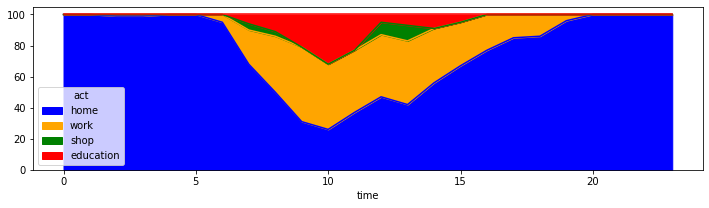

In [205]:
state_histories = []
hours = range(24)

for p in range(100):
    z_sample = np.array([[np.random.normal(), np.random.normal()]])
    decoded = vae.decoder.predict(z_sample)
    acts = decode(decoded)
    for h, act in zip(hours,acts):
        state_histories.append([p, h, act])

state_histories = pd.DataFrame(state_histories, columns=["pid", "time", "act"])
df = state_histories.groupby('time')['act'].value_counts().unstack(level=1).fillna(0)
cmap = {'home':'blue','work':'orange','shop':'green', 'education': 'red'}

fig, ax = plt.subplots(1,  figsize=(12, 3))
df[["home", "work", "shop", "education"]].plot(kind='area', color=cmap, ax=ax)  

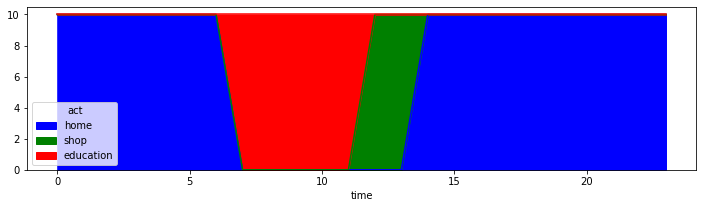

In [211]:
target = [2.5,0.8]

state_histories = []
hours = range(24)

for p in range(10):
    z_sample = np.array([[target[0] + np.random.normal(0,.1), target[1] + np.random.normal(0, 0.1)]])
    decoded = vae.decoder.predict(z_sample)
    acts = decode(decoded)
    for h, act in zip(hours,acts):
        state_histories.append([p, h, act])

state_histories = pd.DataFrame(state_histories, columns=["pid", "time", "act"])
df = state_histories.groupby('time')['act'].value_counts().unstack(level=1).fillna(0)
cmap = {'home':'blue','work':'orange','shop':'green', 'education': 'red'}

fig, ax = plt.subplots(1,  figsize=(12, 3))
df[["home", "shop", "education"]].plot(kind='area', color=cmap, ax=ax)  

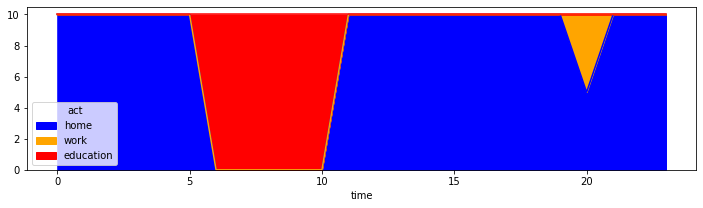

In [212]:
target = [1,3,1.7]

state_histories = []
hours = range(24)

for p in range(10):
    z_sample = np.array([[target[0] + np.random.normal(0,.1), target[1] + np.random.normal(0, 0.1)]])
    decoded = vae.decoder.predict(z_sample)
    acts = decode(decoded)
    for h, act in zip(hours,acts):
        state_histories.append([p, h, act])

state_histories = pd.DataFrame(state_histories, columns=["pid", "time", "act"])
df = state_histories.groupby('time')['act'].value_counts().unstack(level=1).fillna(0)
cmap = {'home':'blue','work':'orange','shop':'green', 'education': 'red'}

fig, ax = plt.subplots(1,  figsize=(12, 3))
df[["home", "work", "education"]].plot(kind='area', color=cmap, ax=ax)  